In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Things to include in the notebook
- Difference between training on the same dataset(s) and crossing dataset
- Try to have it random if it should train on an image from MNIST or SVHN. 
- Try training with different types of preprocessing and data augmentation


# Loading the MNIST dataset


In [2]:

from torchvision.transforms import ToTensor
import torchvision
import torch

# These hyperparameters should be further tested
batch_size = 4
num_workers = 4


mnist_train_dataset = torchvision.datasets.MNIST(root = "data", download = True, transform=ToTensor(), train=True)
mnist_test_dataset = torchvision.datasets.MNIST(root = "data", download = True, transform=ToTensor(), train=False)

mnist_train_data_loader = torch.utils.data.DataLoader(mnist_train_dataset,
                                               batch_size = batch_size,
                                               shuffle = True,
                                               )
mnist_test_data_loader = torch.utils.data.DataLoader(mnist_test_dataset,
                                               batch_size = batch_size,
                                               shuffle = True,
                                               )

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Loading the SVHN dataset

In [3]:
svhn_train_dataset = torchvision.datasets.SVHN(root="data", split='train', download=True, transform=ToTensor())
svhn_test_dataset = torchvision.datasets.SVHN(root="data", split='test', download=True, transform=ToTensor())

svhn_train_data_loader = torch.utils.data.DataLoader(svhn_train_dataset,
                                         batch_size = batch_size,
                                         shuffle = True,
                                         )

svhn_test_data_loader = torch.utils.data.DataLoader(svhn_test_dataset,
                                         batch_size = batch_size,
                                         shuffle = True,
                                         )


  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]

# Visualizing the MNIST dataset

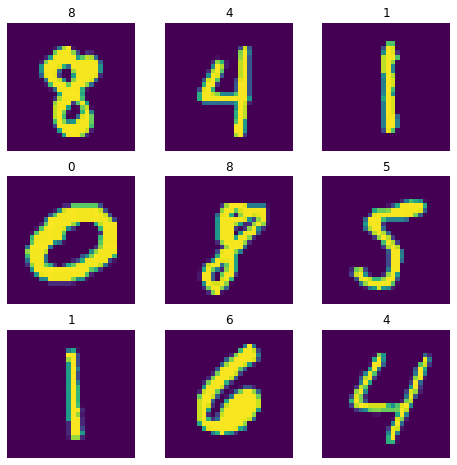

In [4]:
from matplotlib import pyplot as plt

figure = plt.figure(figsize =(8,8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_train_dataset), size=(1,)).item()
    img, label = mnist_train_dataset[sample_idx]
    ax = figure.add_subplot(rows, cols, i)
    ax.set_title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

# Visualizing the SVHN dataset


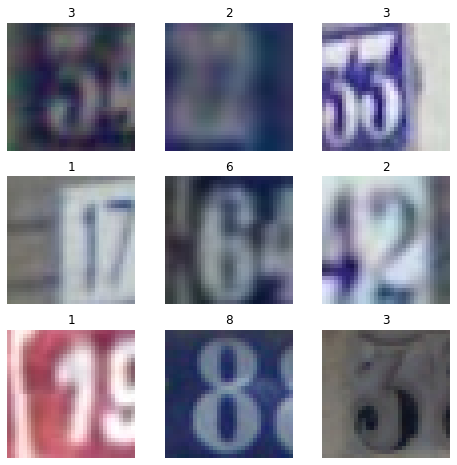

In [5]:
figure = plt.figure(figsize =(8,8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(svhn_train_dataset), size=(1,)).item()
    img, label = svhn_train_dataset[sample_idx]
    img = img.permute(1, 2, 0)
    ax1 = figure.add_subplot(rows, cols, i)
    ax1.set_title(label)
    plt.axis("off")
    plt.imshow(img.squeeze())

plt.show()

# Creating 2d-array with all the tensors based on label

In [6]:
import numpy as np


mnist_arr = []
svhn_arr = []

for i in range(10):
    mnist_arr.append([])
    svhn_arr.append([])

for num, item in enumerate(svhn_train_dataset):
    svhn_img = item[0].permute(1, 2, 0)
    svhn_arr[item[1]].append(svhn_img)

for num, item in enumerate(mnist_train_dataset):    
    mnist_arr[item[1]].append(item[0])



# Inspecting images at same position

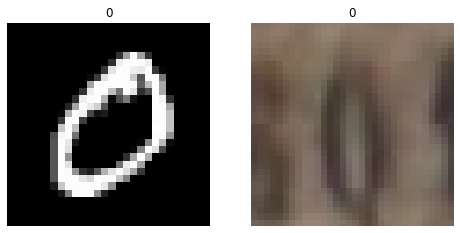

In [34]:
import random
pos1 = random.randint(0, 9)
pos2 = random.randint(0,min(len(mnist_arr), len(svhn_arr)))


figure = plt.figure(figsize =(8,8))
mnist_img = mnist_arr[pos1][pos2]
svhn_img = svhn_arr[pos1][pos2]


ax = figure.add_subplot(1, 2, 1)
ax.set_title(pos1)
plt.axis("off")
plt.imshow(mnist_img.squeeze(), cmap="gray")
ax = figure.add_subplot(1, 2, 2)
ax.set_title(pos1)
plt.axis("off")
plt.imshow(svhn_img.squeeze())

plt.show()



# Visualizing the distribution of labels from both datasets

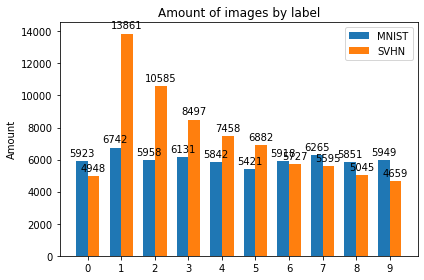

In [8]:

labels = np.arange(0, 10)
len_mnist = [0] * 10
len_svhn = [0] * 10

for i in range(10):
    len_mnist[i] = len(mnist_arr[i])
    len_svhn[i] = len(svhn_arr[i])
    
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(labels - width/2, len_mnist, width, label='MNIST')
rects2 = ax.bar(labels + width/2, len_svhn, width, label='SVHN')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Amount')
ax.set_title('Amount of images by label')
ax.set_xticks(labels, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

# Data preprocessing - Exploration phase


## Grayscale



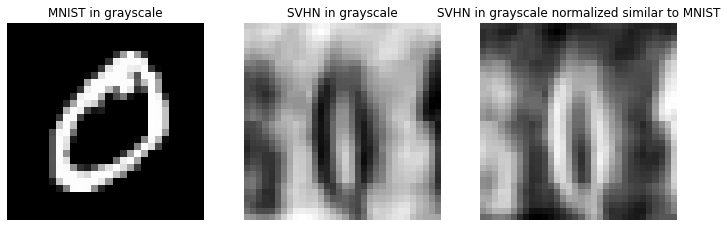

In [29]:
import torchvision.transforms as T
import cv2 as cv

test_img_mnist = mnist_arr[0][0]
test_img_svhn = svhn_arr[0][0]


test_img_svhn = torch.movedim(test_img_svhn, 2, 0)

gray_svhn = T.Grayscale()(test_img_svhn)

gray_svhn2 = gray_svhn


gray_svhn = torch.movedim(gray_svhn, 0, 2)

gray_svhn2 = gray_svhn2.detach().numpy()
gray_svhn2 = cv.normalize(gray_svhn2, None, alpha = 0, beta = 255, norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)
gray_svhn2 = 255 - gray_svhn2

figure = plt.figure(figsize =(12,8))
ax = figure.add_subplot(2, 3, 1)
plt.axis("off")
ax.set_title("MNIST in grayscale")
plt.imshow(test_img_mnist.squeeze(), cmap="gray")

ax = figure.add_subplot(2, 3, 2)
plt.axis("off")
ax.set_title("SVHN in grayscale")
plt.imshow(gray_svhn.squeeze(), cmap="gray")

ax = figure.add_subplot(2, 3, 3)
plt.axis("off")
ax.set_title("SVHN in grayscale normalized similar to MNIST")
plt.imshow(gray_svhn2.squeeze(), cmap="gray")

plt.show()


## Threshold


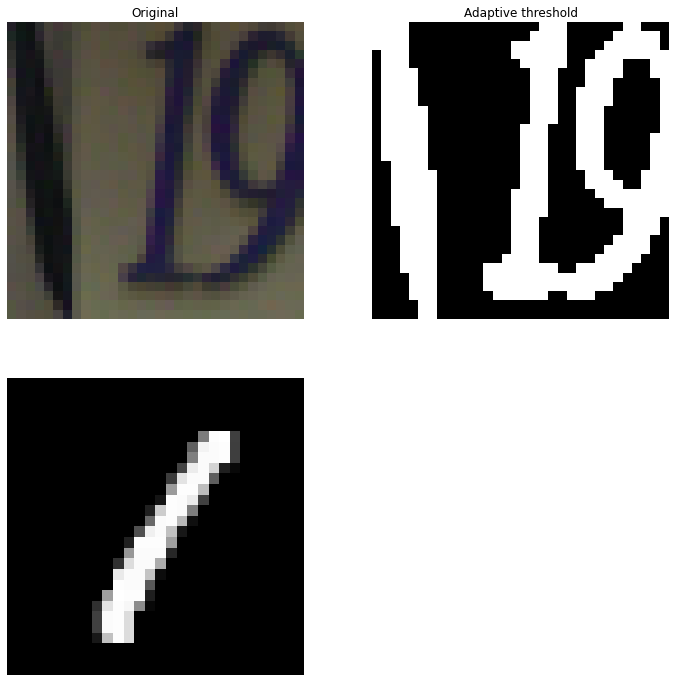

In [69]:

svhn_img = svhn_arr[1][0]
mnist_img = mnist_arr[1][0]

svhn = svhn_img.detach().numpy()
mnist = mnist_img.detach().numpy()

svhn_grey = cv.normalize(svhn, None, alpha = 0, beta = 255, norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)
svhn_grey = cv.cvtColor(svhn_grey, cv.COLOR_BGR2GRAY)
svhn_grey = svhn_grey.astype(np.uint8)

svhn_threshold = cv.adaptiveThreshold(svhn_grey, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)
svhn_threshold = cv.bitwise_not(svhn_threshold)

mnist = cv.normalize(mnist, None, alpha = 0, beta = 255, norm_type = cv.NORM_MINMAX, dtype = cv.CV_8UC1)
mnist = mnist.astype(np.uint8)
#mnist_threshold = cv.adaptiveThreshold(mnist, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)


figure = plt.figure(figsize =(12,12))

ax = figure.add_subplot(2, 2, 1)
ax.set_title("Original")
plt.axis("off")
plt.imshow(svhn.squeeze(), cmap="gray")

ax = figure.add_subplot(2, 2, 2)
ax.set_title("Adaptive threshold")
plt.axis("off")
plt.imshow(svhn_threshold.squeeze(), cmap="gray")

figure.add_subplot(2, 2, 3)
plt.axis("off")
plt.imshow(mnist_frame.squeeze(), cmap="gray")

figure.add_subplot(2, 2, 4)
plt.axis("off")

plt.show()

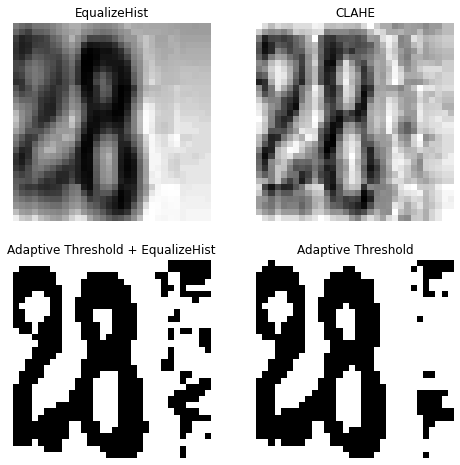

In [32]:
image = svhn_arr[8][0]

image = image.detach().numpy()
image = cv.normalize(image, None, alpha = 0, beta = 255, norm_type = cv.NORM_MINMAX, dtype = cv.CV_32F)
image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
image = image.astype(np.uint8)

image2 = image 
image4 = image

image = cv.equalizeHist(image)
clahe = cv.createCLAHE(clipLimit=3.,)
image2 = clahe.apply(image2)

image3 = cv.adaptiveThreshold(image, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)
image4 = cv.adaptiveThreshold(image4, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)


figure = plt.figure(figsize =(8,8))

ax = figure.add_subplot(2, 2, 1)
ax.set_title("EqualizeHist")
plt.axis("off")
plt.imshow(image.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 2)
ax.set_title("CLAHE")
plt.axis("off")
plt.imshow(image2.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 3)
ax.set_title("Adaptive Threshold + EqualizeHist")
plt.axis("off")
plt.imshow(image3.squeeze(), cmap="gray")
ax = figure.add_subplot(2, 2, 4)
ax.set_title("Adaptive Threshold")
plt.axis("off")
plt.imshow(image4.squeeze(), cmap="gray")